In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from mcmclib.metropolis import mala_adapt

import os
import json
import pandas as pd
from base_rl_mcmc.toolbox import flat
import bridgestan as bs
from posteriordb import PosteriorDatabase

import stan

import nest_asyncio
nest_asyncio.apply()

In [2]:
# Load DataBase Locally
pdb_path = os.path.join(os.getcwd(), "posteriordb/posterior_database")
my_pdb = PosteriorDatabase(pdb_path)

# Load Dataset
posterior = my_pdb.posterior("test-multivariant_normal-test-multivariant_normal")
stan_file_path = posterior.model.stan_code_file_path()
data = json.dumps(posterior.data.values())
model = bs.StanModel.from_stan_file(stan_file_path, data)

# Gold Standard
gs = posterior.reference_draws()
df = pd.DataFrame(gs)
gs_chains = np.zeros((sum(flat(posterior.information['dimensions'].values())),\
                       posterior.reference_draws_info()['diagnostics']['ndraws']))
for i in range(len(df.keys())):
    s = []
    for j in range(len(df[df.keys()[i]])):
        s += df[df.keys()[i]][j]
    gs_chains[i, :] = s
linv = np.linalg.inv(np.cov(gs_chains))

# Extract log-P-pdf and its gradient
log_p = model.log_density
grad_log_p = lambda x: model.log_density_gradient(x)[1]
hess_log_p = lambda x: model.log_density_hessian(x)[2]

Bridgestan not found at location specified by $BRIDGESTAN environment variable, downloading version 2.2.1 to /home/congye/.bridgestan/bridgestan-2.2.1
Done!


In [3]:
alpha = 10 * [0.3]
epoch = 9 * [1_000] + [1_1000]
x, _, _, _, _, _ = mala_adapt(
    fp=log_p,
    fg=grad_log_p,
    x0=np.array([0.,0.]),
    h0=0.1,
    c0=np.eye(2),
    alpha=alpha,
    epoch=epoch,
    pb=True)

100%|██████████| 9/9 [00:03<00:00,  2.68it/s]


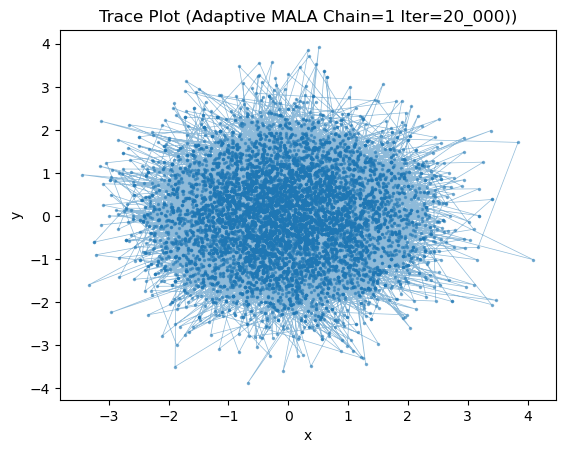

In [4]:
plt.plot(x[-1][:, 0], x[-1][:, 1], 'o-', linewidth=0.5, markersize=1.5, alpha=0.5)
plt.title("Trace Plot (Adaptive MALA Chain=1 Iter=20_000))")
plt.xlabel("x")
plt.ylabel("y")
plt.show()

/home/congye/Software/anaconda3/envs/rl/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/congye/Software/anaconda3/envs/rl/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/congye/Software/anaconda3/envs/rl/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/congye/Software/anaconda3/envs/rl/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will 

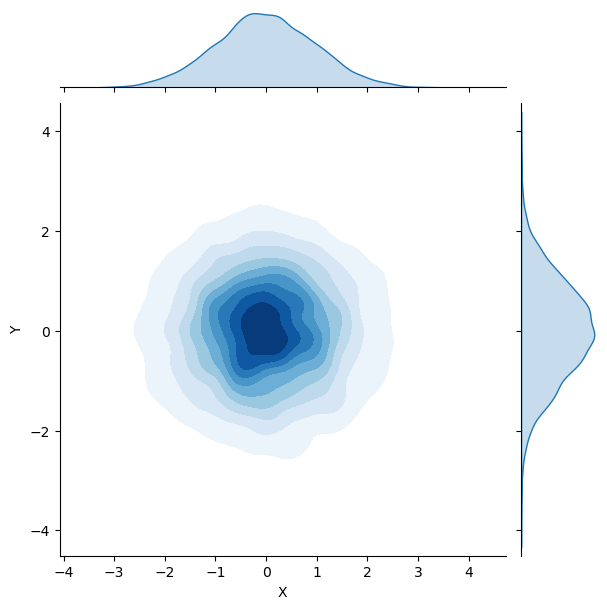

In [5]:
# Marginal Plot
sns.jointplot(x=x[-1][:, 0], y=x[-1][:, 1], kind='kde', cmap='Blues', fill=True)
plt.xlabel('X')
plt.ylabel('Y')
plt.show()

In [6]:
num = 1000
x = np.linspace(-15, 15, num)
y = np.linspace(-15, 15, num)
X, Y = np.meshgrid(x, y)

Z = np.zeros((num, num))

In [7]:
for i in range(len(x)):
    for j in range(len(y)):
        Z[i, j] = np.exp(log_p(np.array([x[i], y[j]])))

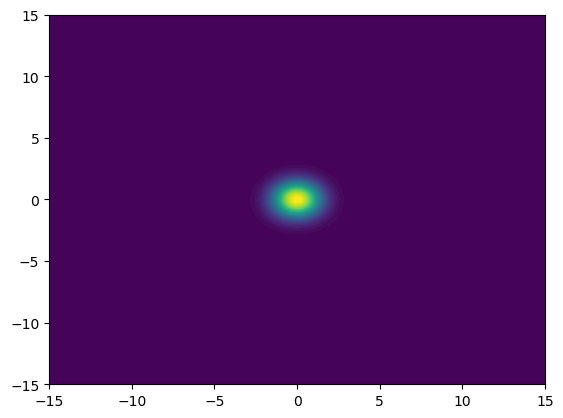

In [8]:
plt.contourf(X, Y, Z.T, 50, cmap='viridis')

Building...

/home/congye/.cache/httpstan/4.10.1/models/nqfppgoh/model_nqfppgoh.cpp: In constructor ‘model_nqfppgoh_namespace::model_nqfppgoh::model_nqfppgoh(stan::io::var_context&, unsigned int, std::ostream*)’:
/home/congye/.cache/httpstan/4.10.1/models/nqfppgoh/model_nqfppgoh.cpp:33:11: warning: variable ‘pos__’ set but not used [-Wunused-but-set-variable]
   33 |       int pos__ = std::numeric_limits<int>::min();
      |           ^~~~~
In file included from /home/congye/Software/anaconda3/envs/rl/lib/python3.10/site-packages/httpstan/include/stan/math/prim/fun.hpp:124,
                 from /home/congye/Software/anaconda3/envs/rl/lib/python3.10/site-packages/httpstan/include/stan/math/rev/fun/multiply.hpp:7,
                 from /home/congye/Software/anaconda3/envs/rl/lib/python3.10/site-packages/httpstan/include/stan/math/rev/fun/elt_multiply.hpp:9,
                 from /home/congye/Software/anaconda3/envs/rl/lib/python3.10/site-packages/httpstan/include/stan/math/rev/fun.hpp:55,
          


Building: 11.5s, done.Sampling:   0%
Sampling: 100% (11000/11000)
Sampling: 100% (11000/11000), done.
Messages received during sampling:
  Gradient evaluation took 6e-06 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.06 seconds.
  Adjust your expectations accordingly!


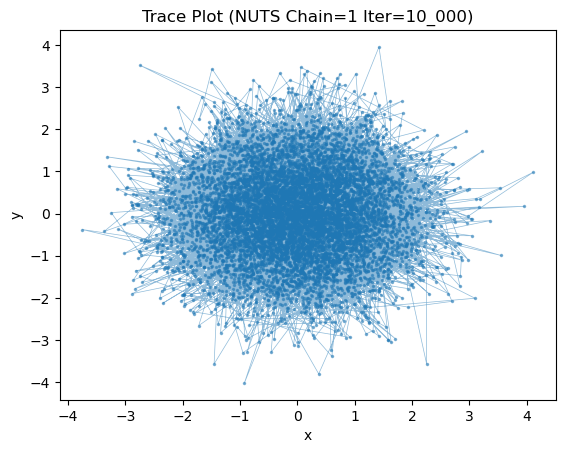

In [9]:
stan_sampler = stan.build(posterior.model.stan_code(), data=posterior.data.values(), random_seed=1234)

fit_single_chain = stan_sampler.sample(num_chains=1, num_samples=10_000)
df_single_chain = fit_single_chain.to_frame()

plt.plot(df_single_chain["x.1"], df_single_chain["x.2"], 'o-', linewidth=0.5, markersize=1.5, alpha=0.5)
plt.title("Trace Plot (NUTS Chain=1 Iter=10_000)")
plt.xlabel("x")
plt.ylabel("y")
plt.show()

/home/congye/Software/anaconda3/envs/rl/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/congye/Software/anaconda3/envs/rl/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/congye/Software/anaconda3/envs/rl/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/congye/Software/anaconda3/envs/rl/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will 

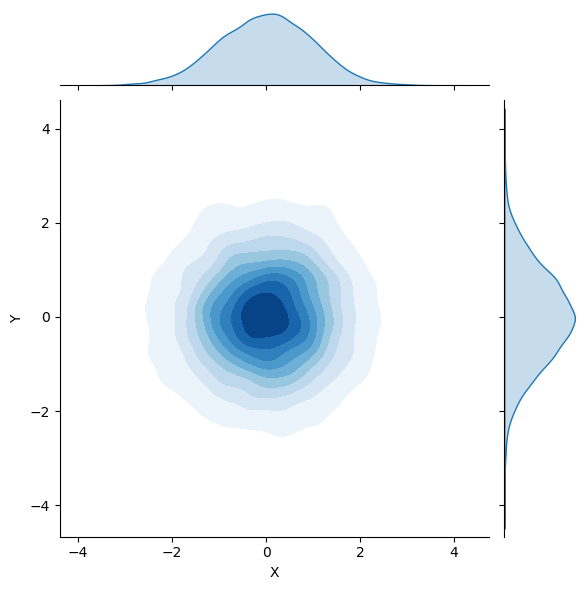

In [10]:
# Marginal Plot
sns.jointplot(x=df_single_chain["x.1"], y=df_single_chain["x.2"], kind='kde', cmap='Blues', fill=True)
plt.xlabel('X')
plt.ylabel('Y')
plt.show()

Sampling:   0%
Sampling: 100% (1001000/1001000)
Sampling: 100% (1001000/1001000), done.
Messages received during sampling:
  Gradient evaluation took 5e-06 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.05 seconds.
  Adjust your expectations accordingly!


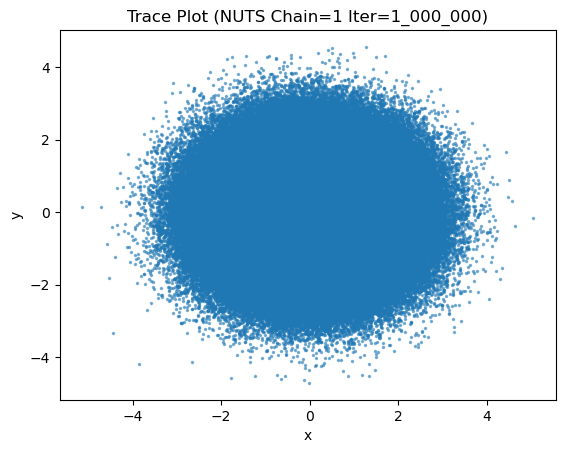

In [11]:
fit_single_chain_million = stan_sampler.sample(num_chains=1, num_samples=1_000_000)
df_single_chain_million = fit_single_chain_million.to_frame()

plt.plot(df_single_chain_million["x.1"], df_single_chain_million["x.2"], 'o', linewidth=0.5, markersize=1.5, alpha=0.5)
plt.title("Trace Plot (NUTS Chain=1 Iter=1_000_000)")
plt.xlabel("x")
plt.ylabel("y")
plt.show()

/home/congye/Software/anaconda3/envs/rl/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/congye/Software/anaconda3/envs/rl/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/congye/Software/anaconda3/envs/rl/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/congye/Software/anaconda3/envs/rl/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will 

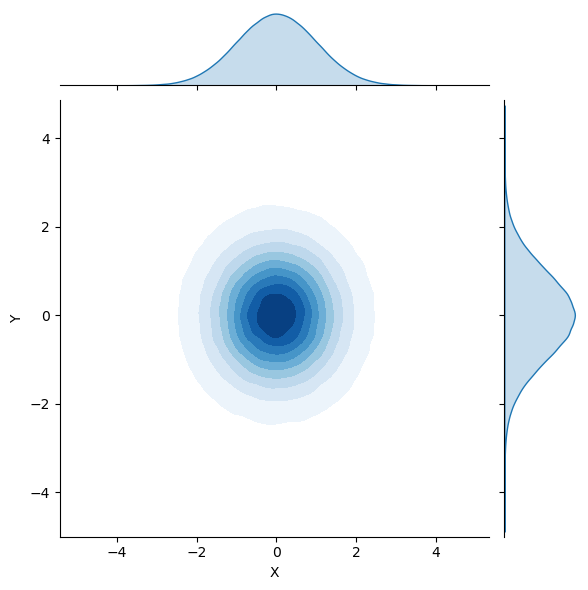

In [12]:
# Marginal Plot
sns.jointplot(x=df_single_chain_million["x.1"], y=df_single_chain_million["x.2"], kind='kde', cmap='Blues', fill=True)
plt.xlabel('X')
plt.ylabel('Y')
plt.show()

In [13]:
fit_4_chain = stan_sampler.sample(
    num_chains=4,
    num_samples=10_000,
    init=[
        {"x": [0.0, 0.0]},
        {"x": [0.0, 0.0]},
        {"x": [0.0, 0.0]},
        {"x": [0.0, 0.0]}
        ]
    )
df_4_chain = fit_4_chain.to_frame()

fit_4_chain1 = np.vstack((fit_4_chain._draws[-2, :, 0], fit_4_chain._draws[-1, :, 0]))
fit_4_chain2 = np.vstack((fit_4_chain._draws[-2, :, 1], fit_4_chain._draws[-1, :, 1]))
fit_4_chain3 = np.vstack((fit_4_chain._draws[-2, :, 2], fit_4_chain._draws[-1, :, 2]))
fit_4_chain4 = np.vstack((fit_4_chain._draws[-2, :, 3], fit_4_chain._draws[-1, :, 3]))

Sampling:   0%
Sampling:  25% (11000/44000)
Sampling:  50% (22000/44000)
Sampling:  75% (33000/44000)
Sampling: 100% (44000/44000)
Sampling: 100% (44000/44000), done.
Messages received during sampling:
  Gradient evaluation took 7e-06 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.07 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 6e-06 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.06 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 5e-06 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.05 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 5e-06 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.05 seconds.
  Adjust your expectations accordingly!


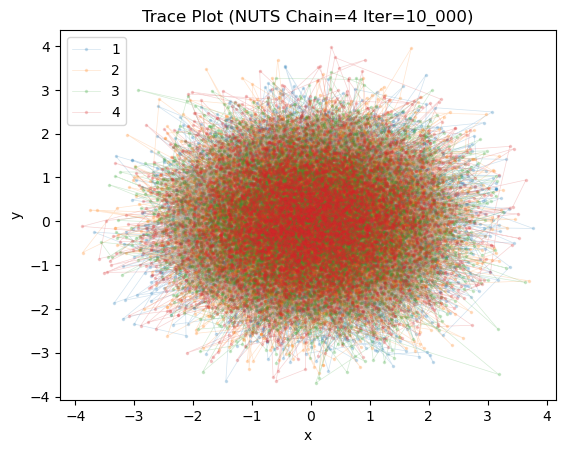

In [14]:
plt.plot(fit_4_chain1[0,:], fit_4_chain1[1,:], 'o-', linewidth=0.5, markersize=1.5, alpha=0.2, label="1")
plt.plot(fit_4_chain2[0,:], fit_4_chain2[1,:], 'o-', linewidth=0.5, markersize=1.5, alpha=0.2, label="2")
plt.plot(fit_4_chain3[0,:], fit_4_chain3[1,:], 'o-', linewidth=0.5, markersize=1.5, alpha=0.2, label="3")
plt.plot(fit_4_chain4[0,:], fit_4_chain4[1,:], 'o-', linewidth=0.5, markersize=1.5, alpha=0.2, label="4")
plt.title("Trace Plot (NUTS Chain=4 Iter=10_000)")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.show()

/home/congye/Software/anaconda3/envs/rl/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/congye/Software/anaconda3/envs/rl/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/congye/Software/anaconda3/envs/rl/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/congye/Software/anaconda3/envs/rl/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will 

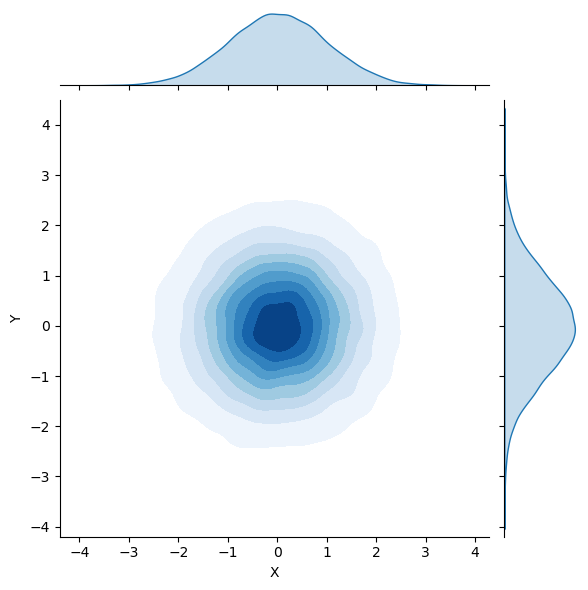

In [15]:
# Marginal Plot
sns.jointplot(x=df_4_chain["x.1"], y=df_4_chain["x.2"], kind='kde', cmap='Blues', fill=True)
plt.xlabel('X')
plt.ylabel('Y')
plt.show()

In [16]:
fit_10_chain = stan_sampler.sample(
    num_chains=10,
    num_samples=10_000,
    init=[{"x": [0,0]} for _ in range(10)]
    )
df_10_chain = fit_10_chain.to_frame()

for i in range(10):
    exec(f"fit_10_chain{i+1} = np.vstack((fit_10_chain._draws[-2, :, {i}], fit_10_chain._draws[-1, :, {i}]))")

Sampling:   0%
Sampling:  10% (11000/110000)
Sampling:  20% (22000/110000)
Sampling:  30% (33000/110000)
Sampling:  40% (44000/110000)
Sampling:  50% (55000/110000)
Sampling:  60% (66000/110000)
Sampling:  70% (77000/110000)
Sampling:  80% (88000/110000)
Sampling:  90% (99000/110000)
Sampling: 100% (110000/110000)
Sampling: 100% (110000/110000), done.
Messages received during sampling:
  Gradient evaluation took 6e-06 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.06 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 6e-06 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.06 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 5e-06 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.05 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 5e-06 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.05 seco

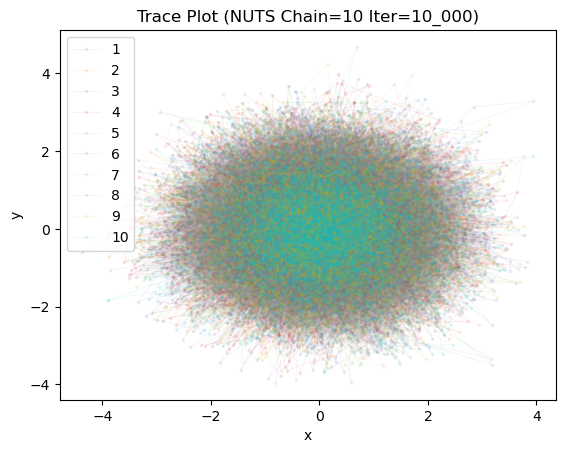

In [17]:
for i in range(10):
    exec(f'plt.plot(fit_10_chain{i+1}[0,:], fit_10_chain{i+1}[1,:], "o-", linewidth=0.5, markersize=1.5, alpha=0.1, label="{i+1}")')
plt.title("Trace Plot (NUTS Chain=10 Iter=10_000)")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.show()

/home/congye/Software/anaconda3/envs/rl/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/congye/Software/anaconda3/envs/rl/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/congye/Software/anaconda3/envs/rl/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/congye/Software/anaconda3/envs/rl/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will 

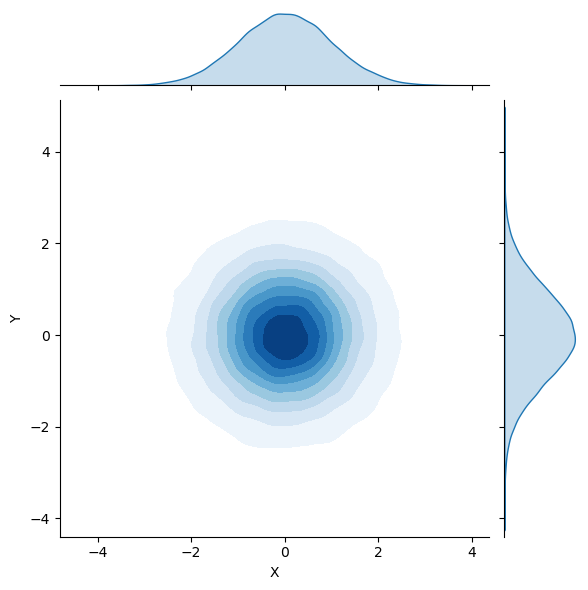

In [18]:
# Marginal Plot
sns.jointplot(x=df_10_chain["x.1"], y=df_10_chain["x.2"], kind='kde', cmap='Blues', fill=True)
plt.xlabel('X')
plt.ylabel('Y')
plt.show()

In [19]:
fit_20_chain = stan_sampler.sample(
    num_chains=20,
    num_samples=10_000,
    init=[{"x": [0,0]} for _ in range(20)]
    )
df_20_chain = fit_20_chain.to_frame()

for i in range(20):
    exec(f"fit_20_chain{i+1} = np.vstack((fit_20_chain._draws[-2, :, {i}], fit_20_chain._draws[-1, :, {i}]))")

Sampling:   0%
Sampling:   5% (11000/220000)
Sampling:  10% (22000/220000)
Sampling:  15% (33000/220000)
Sampling:  20% (44000/220000)
Sampling:  25% (55000/220000)
Sampling:  30% (66000/220000)
Sampling:  35% (77000/220000)
Sampling:  40% (88000/220000)
Sampling:  45% (99000/220000)
Sampling:  50% (110000/220000)
Sampling: 100%, done.
Messages received during sampling:
  Gradient evaluation took 6e-06 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.06 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 6e-06 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.06 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 5e-06 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.05 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 5e-06 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.05 seconds.
  Adjust yo

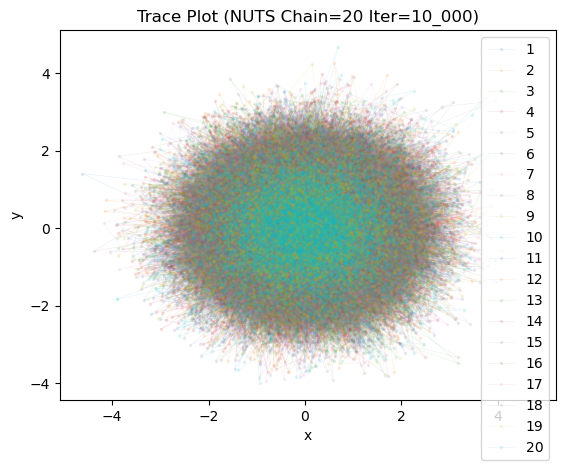

In [20]:
for i in range(20):
    exec(f'plt.plot(fit_20_chain{i+1}[0,:], fit_20_chain{i+1}[1,:], "o-", linewidth=0.5, markersize=1.5, alpha=0.1, label="{i+1}")')
plt.title("Trace Plot (NUTS Chain=20 Iter=10_000)")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.show()

/home/congye/Software/anaconda3/envs/rl/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/congye/Software/anaconda3/envs/rl/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/congye/Software/anaconda3/envs/rl/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/congye/Software/anaconda3/envs/rl/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will 

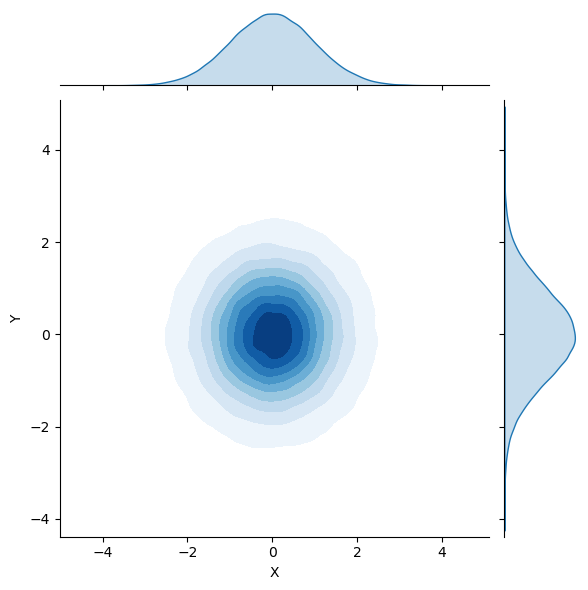

In [21]:
# Marginal Plot
sns.jointplot(x=df_20_chain["x.1"], y=df_20_chain["x.2"], kind='kde', cmap='Blues', fill=True)
plt.xlabel('X')
plt.ylabel('Y')
plt.show()